# Laboratory 2

In this second laboratory you will implement (from scratch) and train two simple classifiers: the softmax classifier.

Don't worry, starting from the next laboratory we'll be using a popular machine learning library, but for now it is very important to understand the anatomy of these simple models.
 
Another important aspect that we'll be discussing today is how to properly evaluate a classifier.




In [253]:
%load_ext autoreload
%autoreload 2
import os
import sys
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [254]:
#!rm -rf cvdl_lab2_students
#![ -d cvdl_lab2_students ] || git clone https://github.com/dianalauraborza/cvdl_lab2_students.git

In [255]:
#from google.colab import files
#files.view('cvdl_lab2_students/lab2/metrics.py')
#files.view('cvdl_lab2_students/lab2/softmax.py')
#files.view('cvdl_lab2_students/lab2/activations.py')

#import sys
#if './cvdl_lab2_students' not in sys.path:
#  sys.path.append('./cvdl_lab2_students')

## Warm-up

Let's start by implementing the softmax function. This function takes as input an array of *N* arbitrary numbers and normalizes the array such that the output is a probability distribution.


\begin{equation}
softmax(x)_i = \frac{e^{x_i}}{\sum_{j = 0}^{j = N} e^{x_j}}
\end{equation}

In the file *activations.py* write the implementation of the softmax function.

**Short discussion about softmax numerical stability.** You can also check this [post](https://ogunlao.github.io/2020/04/26/you_dont_really_know_softmax.html)

In [256]:

# validate softmax
import numpy as np
import tensorflow as tf
from lab2.activations import *
# let's check that you obtained the same values 
# as the softmax implementation in tensorflow
arr = np.asarray([[2, 4, 10, 100000, 2.0], [-750.0, 23, 9, 10, 230]])
assert (np.allclose(tf.nn.softmax(arr).numpy(), softmax(arr)))

arr = np.asarray([2, 4, 10, 100000, 2.0])
assert (np.allclose(tf.nn.softmax(arr).numpy(), softmax(arr)))

arr = np.asarray([0.0, 0, 0, 1, 0])
assert (np.allclose(tf.nn.softmax(arr).numpy(), softmax(arr)))
arr = np.asarray([-750.0, 23, 9, 10, 230])
assert (np.allclose(tf.nn.softmax(arr).numpy(), softmax(arr)))
arr = np.ones((4, ))
assert (np.allclose(tf.nn.softmax(arr).numpy(), softmax(arr)))
arr = np.zeros((4, ))
print("done")

done


*Softmax temperature* is a concept that we'll be using later in this course. 
The *softmax temperature* is a hyper-parameter (positive number) which scales the input of the softmax function to modify the output probabilities.


\begin{equation}
s(x, T)_i = \frac{e^{x_i/T}}{\sum_{j = 0}^{j = N} e^{x_j/T}}
\end{equation}

Now modify your implementation of the softmax function such that it also takes as input the softmax temperature (a positive floating point number). If this parameter is not specified, it should default to 1.


Now let's visualise what is the effect of the softmax temperature. 
Given the input vector *x = [100, 2, -150, 75, 99, 3]* , plot the original vector and the softmax with temperatures $ T \in \{0.25, 0.75, 1, 1.5, 2, 5, 10, 20, 30\} $.
 
You can use a bar plot for this. The title for each plot should be the value of the softmax temperature. Also, make sure that for all the plots the range of the *y* axis is set to (0, 1).
 

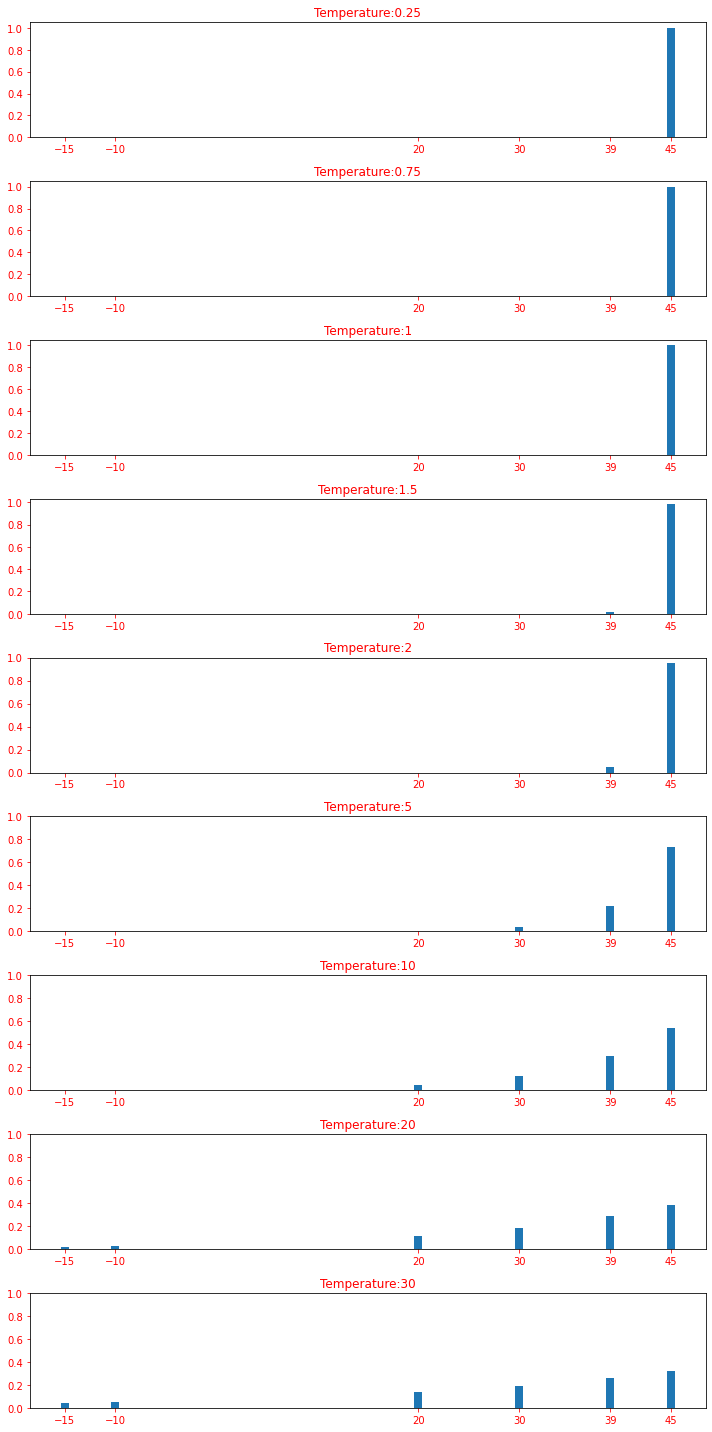

In [257]:
# your code here
import matplotlib.pyplot as plt
x = np.asarray([20, 30, -15, 45, 39, -10])
T = [0.25, 0.75, 1, 1.5, 2, 5, 10, 20, 30]

plt.figure(figsize=(10, 20))
color = 'red'
plt.rcParams['text.color'] = color
plt.rcParams['axes.labelcolor'] = color
plt.rcParams['xtick.color'] = color
plt.rcParams['ytick.color'] = color
for idx in range(0, len(T)):
  # TODO your code here
  # plot the result of applying the softmax function 
  # with different temperatures on the array x
    plt.subplot(len(T), 1, idx+1)
    plt.title(f"Temperature:{T[idx]}")
    plt.bar(x, softmax(x, T[idx]))
    plt.xticks(x)
    plt.yticks(np.arange(0.0, 1.1, 0.2))
plt. tight_layout()
# end TODO your code here


Analyse the plots and answer the following questions:
* What happens when we use a large number for the softmax temperature?
    - the probabilities are more balanced (the classifier is not as confident)
* What happens when we use a small number (i.e. less than 1) for the softmax temperature?
    - the largest number in the input receives a higher probability (classifier is more confident)
* In the context of image classification, the predicted class is determined by taking the *argmax* of the softmax function. Does the softmax temperature change in any way this prediction?
    - no, because each value is divided by the same value before computing the exponential, meaning that the order of probabilities is kept but the scale is different.

## Image classification
 
Image classification refers to the problem of automatically assigning a label (a class) to an image $X_i$. As classification is a supervised learning problem, each image is assigned a ground truth label $y_i \in \{1, 2, ..., C\}$.
 
A linear classifier uses a function $f$ to map an input image $X_i \in R^{H\times W\times 3}$ into a vector of C class scores  $\hat y_i \in R^C$:
 
\begin{equation}
f(X_i) = X_i \cdot W + b
\end{equation}
 
The learnable parameters of the classifier are the weight matrix $W$ and the bias vector $b$. Using the bias trick the bias term can be included in the weight matrix.
 
During the training process, the values of the weight matrix are learned by minimizing a loss function (that penalises the discrepancy between the predicted and the ground truth label).
 
In your implementation, use the bias trick to include the bias term in the weight matrix.
 
## Implementation
 
 
### Softmax classification
 
We'll follow an object oriented approach to solve this problem.
All the code related to the softmax classifier will be implemented in the class *SoftmaxClassifier* (defined in the script _softmax.py_).
 
The class comprises the following methods:
 
| Method                               | Description |
| ----------- | ----------- |
| initialize()      | This function randomly initializes the weights of the linear classifier.    |
| fit(X_train, y_train, **kwargs)      | This function will learn the weights of the model based on the training data samples (X_train) and their corresponding ground truth (y_train)       |
|  predict(X)                | This function will return the classifier's prediction (the predicted class) for the data passed as parameter.        |
|  predict_proba(X)                | This function will return the classifier's predictions for the data passed as parameters.        |
|  save(path)   | This function will dump the weights of the classifier in the path specified as parameter.        |
|  load(load)   | This function will load the classifier's weights from the path specified as parameter      |
 
Feel free to add any additional helper methods if needed.
 
#### Initialization and persistence 
* the constructor of this class takes as input the flattened size of the input image and the number of output classes, sets the corresponding class variables and calls the _init()_ method.
* fill in the _initialize()_ method. You figure out the shape of the weight matrix based on the input shape and the number of classes. Initialize the weight matrix with small random variables.
__Use the bias trick__!
* fill in the _save_ and _load_ functions. In these functions you should just dump and restore, respectively, the weight matrix to/from the specified file.
 
#### Inference - the _predict_ and _predict\_proba_ methods
 
The inference is quite simple. You just need to compute the dot product between the input and the weight matrix.
You will implement two inference methods:
* _predict_ - this will just return the predicted class label. So you just need to compute the dot product and take the argmax of the result.
* _predict\_proba_ - this will return the class probabilities. So after computing the dot product, you also need to apply the softmax function on the result to normalize it to a probability distribution.
 
#### Training  - the _fit_ method
 
The training process is implemented in the function _fit_.
The loss function for the softmax classifier is defined as:
 
\begin{equation}
L_i = - log(\frac{e^{f_{y_i}}}{\sum_{j}e^{f_j}}).
\end{equation}
 
We just take the negative of the logarithm of the predicted probability for the ground truth class.
In the case of the softmax classifier $\hat y_i$ is always a value in the interval [0, 1] (we use the softmax function to normalize the logits into a probability distribution). 
When the probability of the ground truth class is small (i.e. close to 0), the loss will be very high (theoretically, infinite) [log(0) = -inf]. On the other hand, when the probability of the correct class will be high (i.e. close to 1), then the loss will be close to 0 [log(1) = 0].
 
The loss for can be rewritten as (and this is what you should implement in your code):
 
\begin{equation}
L_i = - f_{y_i} + log(\sum_{j}e^{f_j}).
\end{equation}
 
In the equation above $f(\cdot)$ is the linear score function $f(X_i) = X_i \cdot W $.
To get the value for $f_{y_i}$ (i.e. the score for the ground truth class), you can use numpy indexing.
 
For training the classifier, the loss function must be minimized.
 Using the gradient descent algorithm, the weights of the classifier are updated by taking small steps in the opposite direction of the gradient.
 
\begin{equation}
W += -\lambda * dW 
\end{equation}
, where W is the weight matrix and dW is the gradient with respect to the weight matrix. $\lambda$ is the learning rate (a hyper-parameter of the model).
 
The first step is to determine the analytical gradient of the loss function with respect to parameters of the classifier.
 
For a detailed derivation of the gradient for the softmax loss you can check out this [post](https://eli.thegreenplace.net/2016/the-softmax-function-and-its-derivative/).
 

To compute the gradient you need to perform the following operation:
 
\begin{equation}
dW = X^T \cdot CT .
\end{equation}
 
 , where X stores the images in the current batch, $^T$ is the transpose operator and CT is an n-dimensional array of shape _(batch\_size, C)_ and each row _i_ of CT is defined as
\begin{equation}
CT_{i} = s(X_i \cdot W) - \delta_{y_i}
\end{equation}
 
In the equation above $s(\cdot)$ is the softmax function, $X_i$ is the i-th training example and $\delta_{y_i}$ is the one hot encoded value of the ground truth $y_i$ (i.e a vector of size C (number of classes) filled with zeros, except for the index of the ground truth class where we have a value of 1). 
In other words, you will use the predicted softmax probabilities, but for the ground truth class you need to subtract 1 from it.
 
If we look at an example, this makes sense.
Let's say that we have a problem with $C = 4$ classes and for a particular example $X_i$ with ground truth class $y_i$ is 2 (classes start at 0), the classifier predicted: $[0.2, 0.2, 0.5, 0.1]$.
The derivative would be $[0.2, 0.2, -0.5, 0.1]$. You can observe that the component for the ground truth class has a negative influence on the loss, so increasing the probability for the ground truth class would result in a lower loss. However, if the classifier increases the probabilities for any of the other classes, this would increase the values of the loss, which is the opposite of our goal (minimizing the loss function).
 
Remember from the lecture that, in order to avoid overfitting, a regularization term is added to the loss function. 
 
You will implement the $L_2$ regularization, in which you also add the  sum of squares of all of the feature weights to the loss.
 
\begin{equation}
L_t = \frac{1}{N} \sum_i -log(L_i) + \rho \cdot \sum_r \sum_c W_{(r, c)}^2.
\end{equation}
 
$\rho$ is the regularization strength, another hyper-parameter of the model.
 
Also, don't forget to add the derivative of the regularization term to the loss.
The gradient with respect to the regularization term is straight forward, it is simply the weight matrix.
You will use mini-batch gradient descent, in which you will perform the parameter update after "seeing" a batch of samples.
 
**Note-1**: in the starter code, you already have the bias trick implemented. Each example in the training and test set has a value of 1 appended to it.
 
**Note-2** You should use vectorization when implementing this.
For example, when computing the score function $f(\cdot)$, $X$ would be a matrix of shape $(bs, D)$ and $W$ a matrix of shape (D, C), where bs is the batch size, D is the size of the input and C is the number of classes. So the result would be a matrix of scores of shape $(bs, C)$, in which you will store, on each line _i_, the predicted scores (a vector of size C) for the _i_-th training example.
 
 

## Dataset

We'll be using CIFAR-10 dataset. 
The dataset comprises 60000 colour images with a resolution of $32 \times 32$, separated into 10 classes, with 6000 images per class. It is already split into train-test subsets, with 50000 training images and 10000 test images.

You can download the data from this [link](https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz).

In [258]:
#!wget https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
#!tar -xvf cifar-10-python.tar.gz

In the script *cifar10.py* you will complete the function *load_cifar10*, which load the data from the archive you just downloaded.

The images of this dataset are are stored in a numpy array, one image per row, in the following order:

"_The first 1024 entries contain the red channel values, the next 1024 the green, and the final 1024 the blue. The image is stored in row-major order, so that the first 32 entries of the array are the red channel values of the first row of the image._"

Your task here is just to manipulate this array, such that each image has the shape (32, 32, 3) and uses RGB ordering.

Now let's visualize some of the images from the CIFAR-10 dataset.

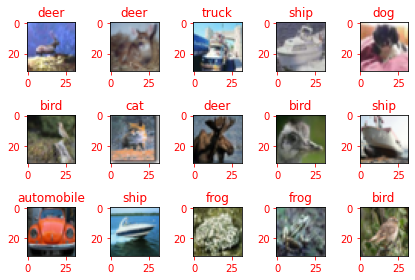

In [259]:
from lab2 import cifar10

cifar_root_dir = 'cifar-10-batches-py'
_, _, X_test, y_test = cifar10.load_ciaf10(cifar_root_dir)
indices = np.random.choice(len(X_test), 15)

display_images, display_labels = X_test[indices], y_test[indices]
for idx, (img, label) in enumerate(zip(display_images, display_labels)):
  plt.subplot(3, 5, idx + 1)
  plt.imshow(img)
  plt.title(cifar10.LABELS[label])
  plt.tight_layout()
plt.show()

## Putting it all together

By now you have implemented all the blocks needed to train a softmax classifier.

Let's train some classifiers using different hyper-parameters.

We'll be using a random search to tune the hyper-parameters of the classifier (the learning rate $\lambda$ and the regularization strength $\rho$)

512 20843.03661779277 100 6.542221151365492e-05
1 171.98531409872862
6 44.07299804005015
11 36.55545534941492
16 35.84870158585732
21 34.72742109574819
26 29.94065224261089
31 28.54401183457884
36 27.738935235131763
41 27.22139848835266
46 27.1163089063285
51 27.080567507240254
56 27.04461114461753
61 27.009192584353727
66 27.00013746967181
71 26.996650257561164
76 26.993198408983886
81 26.989769068222888
86 26.988865347467918
91 26.988525288460956
96 26.988185301606972
lr 0.00006542, reg_strength 20843.03661779, test_acc 0.41590000; train_acc 0.43928000
512 21707.69201391591 100 1.0891825396213698e-05
1 207.84778339395382
6 140.95496240515402
11 98.02604679676563
16 70.94158542393836
21 53.92382635925518
26 51.41931664475323
31 50.23106132762363
36 49.09402076434569
41 48.00781871520409
46 47.801092890631054
51 47.696179625380495
56 47.59185314361376
61 47.48803901568485
66 47.46776696286742
71 47.457425575864725
76 47.44708867906547
81 47.43675624783281
86 47.43473245239048
91 47.433

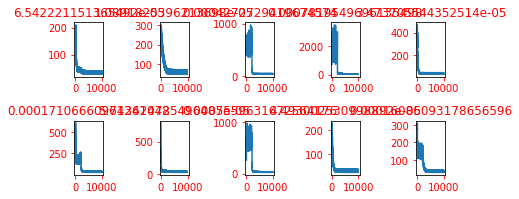

Best softmax: train\softmax_lr0.00004493_reg20657.19311569-test0.41650000.npy


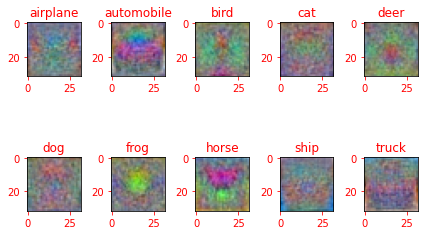

In [333]:
import os
import sys
import random
import numpy as np
from functools import reduce
import matplotlib.pyplot as plt

from lab2 import cifar10 as cifar10
from lab2.softmax import SoftmaxClassifier


cifar_root_dir = 'cifar-10-batches-py'

# the number of trains performed with different hyper-parameters
search_iter = 10
# the batch size
batch_size = 512
# number of training steps per training process
train_steps = 100

# load cifar10 dataset
X_train, y_train, X_test, y_test = cifar10.load_ciaf10(cifar_root_dir)

# convert the training and test data to floating point
X_train = X_train.astype(np.float32)
X_test = X_test.astype(np.float32)

# Reshape the training data such that we have one image per row
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))

# pre-processing: subtract mean image
mean_image = np.mean(X_train, axis=0)
std_image = np.std(X_train, axis=0)
X_train = (X_train-mean_image)/std_image
X_test = (X_test-mean_image)/std_image
#X_train -= mean_image
#X_test -= mean_image

# Bias trick - add 1 to each training example
X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])

# the search limits for the learning rate and regularization strength
# we'll use log scale for the search
lr_bounds = (-7, -2)
reg_strength_bounds = (-4, -2)

if not os.path.exists('train'):
    os.mkdir('train')

best_acc = -1
best_cls_path = ''

learning_rates = [-5, -3]
regularization_strengths = [3000, 80000]

input_size_flattened = reduce((lambda a, b: a * b), X_train[0].shape)
results = []

for index in range(0, search_iter):
    # use log scale for sampling the learning rate
    lr = pow(10, random.uniform(learning_rates[0], learning_rates[1]))
    reg_strength = random.uniform(regularization_strengths[0], regularization_strengths[1])

    cls = SoftmaxClassifier(input_shape=input_size_flattened, num_classes=cifar10.NUM_CLASSES)
    history = cls.fit(X_train, y_train, lr=lr, reg_strength=reg_strength,
            steps=train_steps, bs=batch_size)

    results.append({
        'lr': lr,
        'reg': reg_strength,
        'history': history
    })

    y_train_pred = cls.predict(X_train)
    y_val_pred = cls.predict(X_test)

    train_acc = np.mean(y_train == y_train_pred)

    test_acc = np.mean(y_test == y_val_pred)
    sys.stdout.write('\rlr {:.8f}, reg_strength {:.8f}, test_acc {:.8f}; train_acc {:.8f}'.format(lr, reg_strength, test_acc, train_acc))
    print()
    cls_path = os.path.join('train', 'softmax_lr{:.8f}_reg{:.8f}-test{:.8f}.npy'.format(lr, reg_strength, test_acc))
    cls.save(cls_path)

    if test_acc > best_acc:
        best_acc = test_acc
        best_cls_path = cls_path


num_rows = search_iter//5 + 1
for idx, res in enumerate(results):
    plt.subplot(num_rows, 5, idx + 1)
    plt.plot(res['history'])

plt.tight_layout()
plt.show()

best_softmax = SoftmaxClassifier(input_shape=input_size_flattened, num_classes=cifar10.NUM_CLASSES)
best_softmax.load(best_cls_path)
print(f"Best softmax: {best_cls_path}")

plt.rcParams['image.cmap'] = 'gray'
# now let's display the weights for the best model
weights = best_softmax.get_weights((32, 32, 3))
w_min = np.amin(weights)
w_max = np.amax(weights)
#plt.figure(figsize=(10, 20))
for idx in range(0, cifar10.NUM_CLASSES):
    plt.subplot(2, 5, idx + 1)
    # normalize the weights
    template = 255.0 * (weights[:, :, :, idx].squeeze() - w_min) / (w_max - w_min)
    template = template.astype(np.uint8)
    plt.imshow(template)
    plt.title(cifar10.LABELS[idx])

plt.tight_layout()
plt.show()


# TODO your code here
# use the metrics module to compute the precision, recall and confusion matrix for the best classifier
# end TODO your code here

In [ ]:
# TODO your code here
# use the metrics module to compute the precision, recall and confusion matrix for the best classifier
# end TODO your code here


## Classifier evaluation
 
After the training process, you want to evaluate the model on the test set, such that you can get an idea on how well your model will perform on unseen data.
Ideally the classes in the test set should be balanced (i.e. you should have the same number of samples for each one of the classes).
 
### Confusion matrix and classification metrics
 
The confusion matrix can be considered the foundation stone for evaluating a classifier. As the name states, it's a simple way of visualising whether/how the model is confusing the classes. 
 
Each row of the confusion matrix represents the instances of the ground truth class, while each column represents the instances of the predicted class.
 
<img src="https://2.bp.blogspot.com/-EvSXDotTOwc/XMfeOGZ-CVI/AAAAAAAAEiE/oePFfvhfOQM11dgRn9FkPxlegCXbgOF4QCLcBGAs/s1600/confusionMatrxiUpdated.jpg"/>
 
Based on the confusion matrix, you can compute different classification metrics:
* *accuracy*: this is simply the ratio between the correctly classified samples (either positive or negative) and the total number of samples;
* _precisi**on**_ : this metric measures the ability of the classifier to capture **only** relevant samples;
* _rec**all**_ : this metric measures the ability of the classifier to spot **all** positive samples.
 
As you may have noticed, it is not possible to maximize precision and recall at the same time, as one comes at the cost of another. 
Therefore, the $F_1$ score -- the harmonic mean between precision and recall -- was defined to combine these two metrics into a single numerical value.
 
\begin{equation}
F_1 = 2 \cdot \frac{precision \cdot recall}{precision + recall}
\end{equation}
 
In the file *metrics.py* you should fill in the code for computing the accuracy, precision, recall and f1-score of your classifier.
 
One challenge when implementing these metrics is that you are not allowed to use any repetitive loops (only numpy vectorization).
 

## Additional questions
 
You want to measure the air quality in your city, so you bought an air quality sensor. 
 
However, you notice that your sensor always returns an air quality index equal to 75, no matter where you place it.
 
* What can you say about the precision of the measurements that you perform?
What about the accuracy of these measurements?


Compute the metrics on the best classifier you obtained so far.

In [ ]:
Your answer = 'my answer' #@param {type:"string"}

You determined that the sensor is broken, so you change it with a brand new one. Now everything seems to be ok.
 
To measure the air quality around your house, you place the sensor in different areas: near your favourite scented candle, under your gas central heating exhaust pipe, on your balcony oriented towards the forest/ocean/mountains :) etc.
 
* What can you say about the precision of the measurements that you perform? What about the accuracy of these measurements?


In [ ]:
Your answer = '' #@param {type:"string"}

## Conclusions

In [ ]:
%%html
<marquee style='width: 100%; color: red;'><b>Yay! You're done!</b></marquee>

Please take two minutes of your time and fill in this [form](https://docs.google.com/forms/d/1sjQZKtJ0dbzeZbdihyAd2O04btAx3hbs7A37eXVDcuI) related to this lab. 

Thanks for your valuable feedback and for helping me "test" the labs!

<img src="https://i.imgflip.com/2uxn79.jpg" style="width:300px;"/>
